# **FORECASTING FUTURE WEEKLY SALES OF WALMART**

In [ ]:
#IMPORT NECESSARY LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro


import warnings
warnings.filterwarnings('ignore')

##LOAD THE DATA
data = pd.read_csv('/content/Walmart.csv')
print(data.head())

print("\nThe shape of data:")
print(data.shape)

print(data.describe())

##Find numerical and categorical columns
numerical_columns = data.select_dtypes(exclude='object').columns
categorical_columns = data.select_dtypes(include='object').columns

print("\nNumerical columns:", numerical_columns)
print("\nCategorical columns:", categorical_columns)

##CHECK MISSING VALUES
print("\nMissing values:")
print(data.isnull().sum())

##If missing values found, fill with mean for numerical columns only
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

## For categorical columns, fill with mode
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

##Check for duplicates
print(f"Number of duplicate rows: {data.duplicated().sum()}")


   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  

The shape of data:
(6435, 8)
             Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.0

In [ ]:
# converting date column dtype object to date
data['Date']=pd.to_datetime(data['Date'], format='%d-%m-%Y')

# split day of week, month and year in three column
data['day_of_week'] = data['Date'].dt.day_name() # extract week name from Date column
data["month"] = data['Date'].dt.month_name()   # extract month name from Date column
data["year"] = data['Date'].map(lambda x: x.year).astype("object")     # extract year from Date column and convert it in object type



print("Months:", data['month'].unique())

print("Years:", data['year'].unique())

Months: ['February' 'March' 'April' 'May' 'June' 'July' 'August' 'September'
 'October' 'November' 'December' 'January']
Years: [2010 2011 2012]


####TOP 10 STORES' CONTRIBUTION TO SALES

In [ ]:
# Sort stores by weekly sales in descending order
data_sorted = data.sort_values(by='Weekly_Sales', ascending=False)

# Calculate total sales of top 10 stores
top_10_sales = data_sorted.head(10)['Weekly_Sales'].sum()

# Calculate total sales of all stores
total_sales = data_sorted['Weekly_Sales'].sum()

# Calculate percentage contribution of top 10 stores to total sales
percentage_contribution = (top_10_sales / total_sales) * 100

print("Total weekly sales of top 10 stores:", top_10_sales)
print("Total weekly sales of all stores:", total_sales)
print("Percentage contribution of top 10 stores to total sales: {:.4f}%".format (percentage_contribution*100))

Total weekly sales of top 10 stores: 36169568.77
Total weekly sales of all stores: 6737218987.110001
Percentage contribution of top 10 stores to total sales: 53.6862%


###PLOTS TO VISUALIZE THE DISTRIBUTION OF COLUMNS

<Figure size 1600x1200 with 0 Axes>

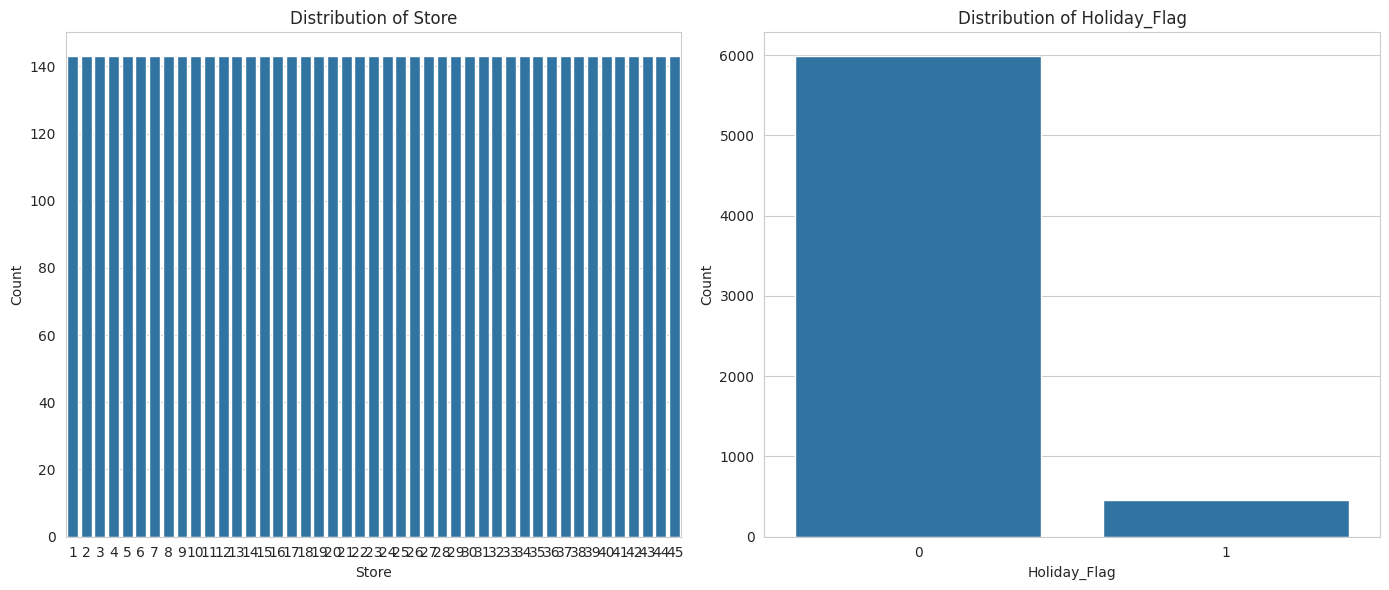

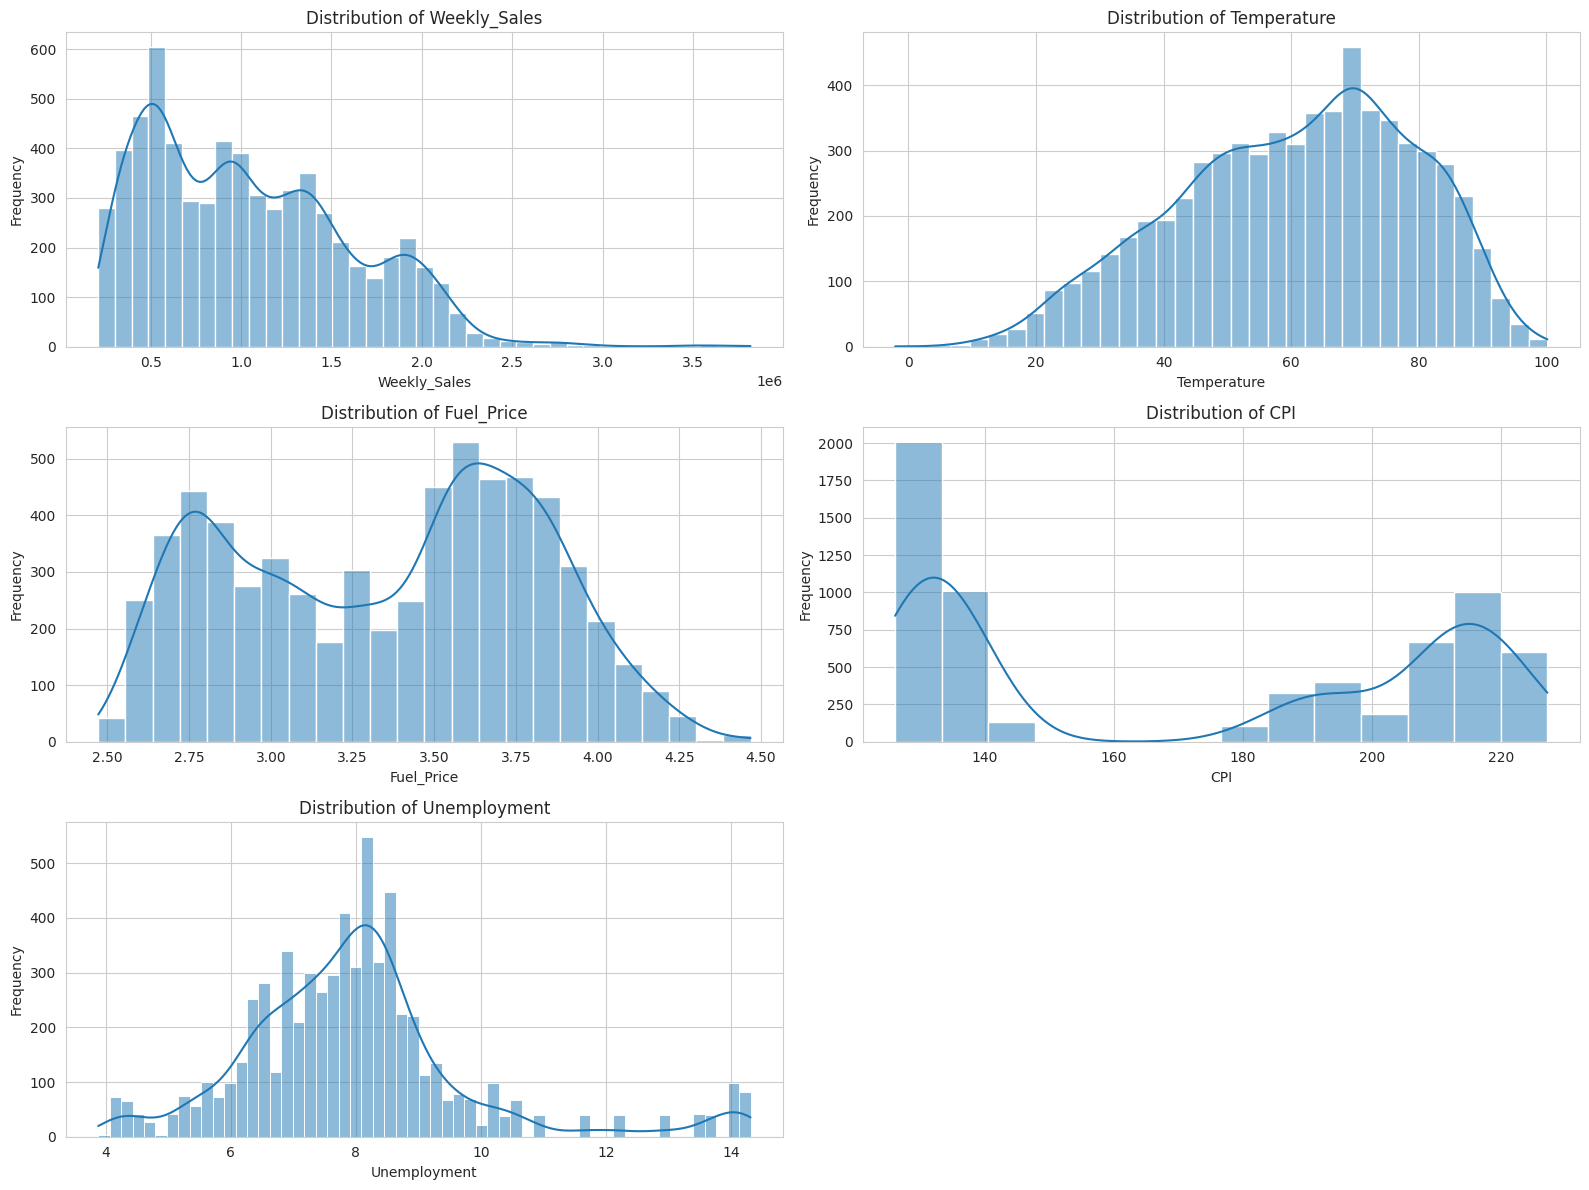

In [ ]:

# Define plot settings
plt.figure(figsize=(16, 12))
sns.set_style('whitegrid')


countplot_columns = ['Store', 'Holiday_Flag']
numerical_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Plot countplots
plt.figure(figsize=(14, 6))
for i, column in enumerate(countplot_columns, 1):
    plt.subplot(1, len(countplot_columns), i)  # Arrange in a single row
    sns.countplot(x=column, data=data)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Plot histograms
plt.figure(figsize=(16, 12))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot((len(numerical_columns) + 1) // 2, 2, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


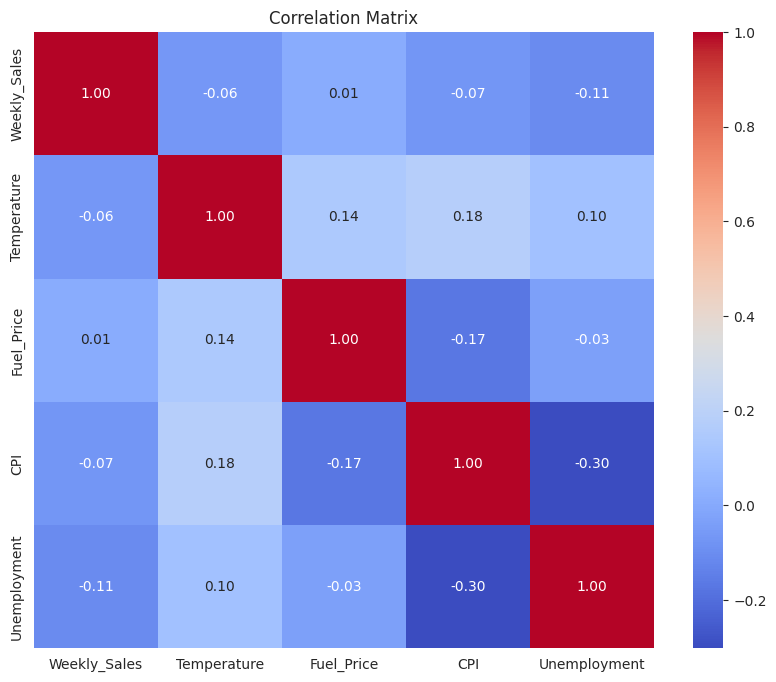

In [ ]:
##Correlation Matrix for numerical columns
correlation_matrix = data[numerical_columns].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
summer =['June','July','August']
winter=['December','January','February']
spring=['March','April','May']
autumn=['September','October','November']

# Define the categorization function
def categorize_season(month):
    if month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['September', 'October', 'November']:
        return 'Autumn'

# Create a new 'season' column based on the 'month' column
data['season'] = data['month'].apply(categorize_season)


###POINT PLOTS FOR THE TARGET VARIABLE TO VIEW SALES OVER SEASONS, MONTHS

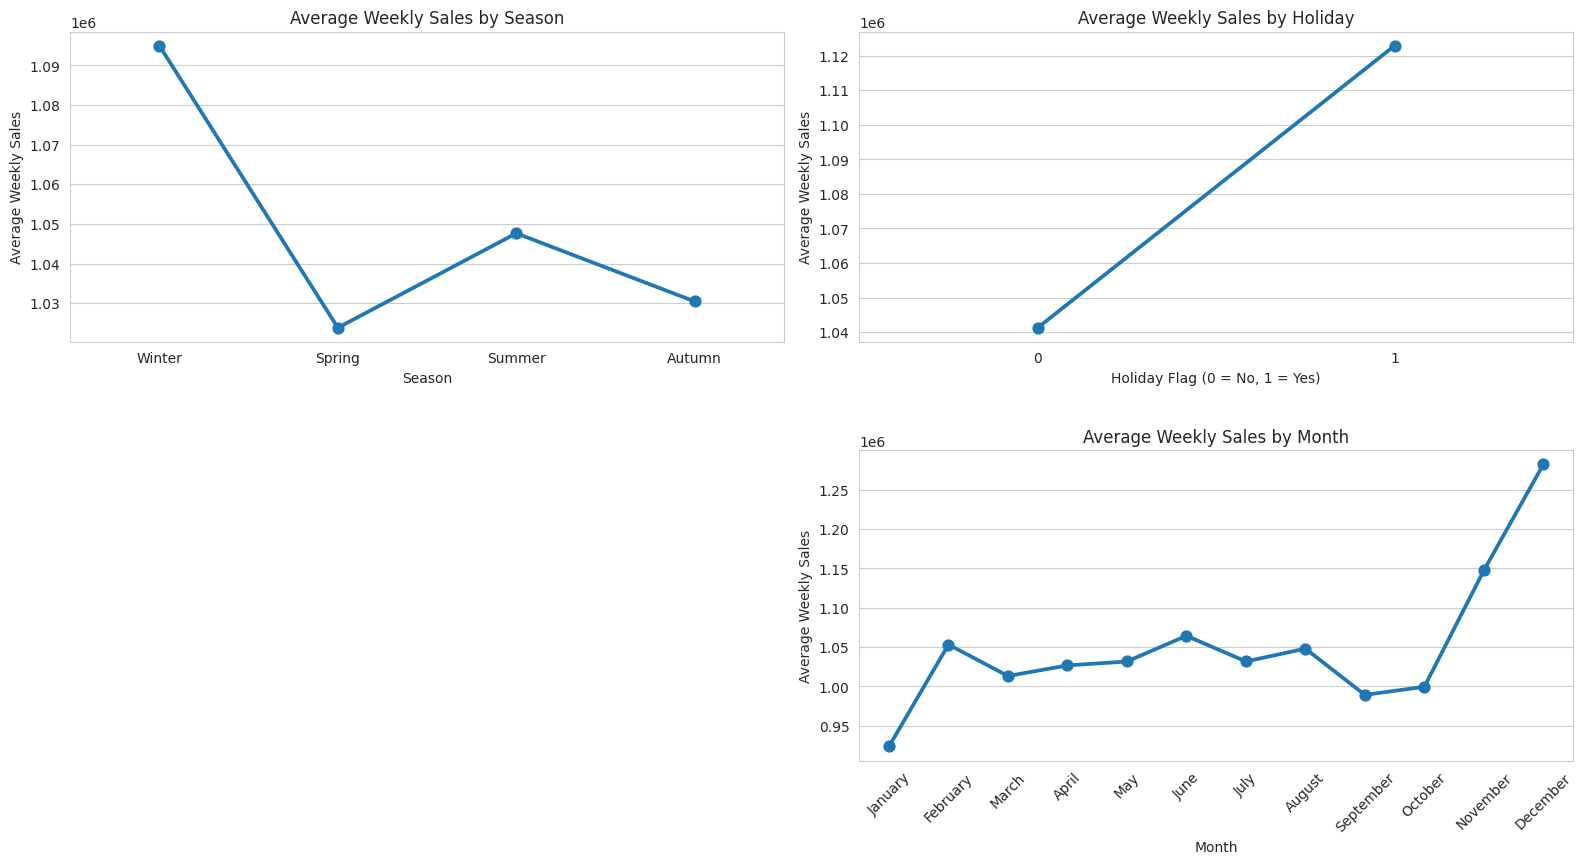

In [ ]:
# Set plot style
sns.set_style('whitegrid')
plt.figure(figsize=(16, 12))

# Point plot for Weekly Sales during different Seasons
plt.subplot(3, 2, 1)
sns.pointplot(x='season', y='Weekly_Sales', data=data, estimator='mean', ci=None)
plt.title('Average Weekly Sales by Season')
plt.xlabel('Season')
plt.ylabel('Average Weekly Sales')

# Point plot for Weekly Sales during Holiday vs Non-Holiday
plt.subplot(3, 2, 2)
sns.pointplot(x='Holiday_Flag', y='Weekly_Sales', data=data, estimator='mean', ci=None)
plt.title('Average Weekly Sales by Holiday')
plt.xlabel('Holiday Flag (0 = No, 1 = Yes)')
plt.ylabel('Average Weekly Sales')


# Point plot for Weekly Sales by Month
plt.subplot(3, 2, 4)
sns.pointplot(x='month', y='Weekly_Sales', data=data, estimator='mean', ci=None,
              order=['January', 'February', 'March', 'April', 'May', 'June',
                     'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability



# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


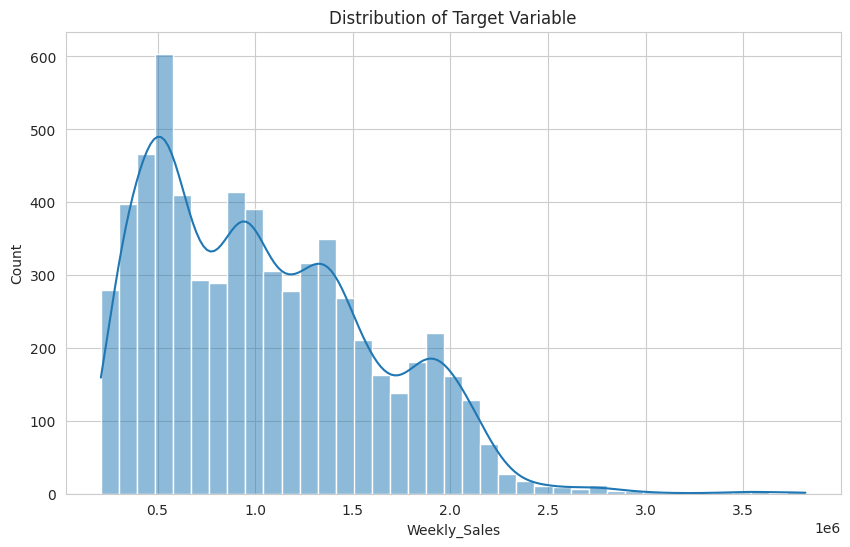

In [ ]:
# Plot distribution of target variable separately
plt.figure(figsize=(10,6))
sns.histplot(data['Weekly_Sales'], kde='True')
plt.title('Distribution of Target Variable')
plt.show()

There is no significance imbalance of the target variable.

In [ ]:
##CUMULATIVE WEEKLY SUM

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Set 'Date' column as index
data.set_index('Date', inplace=True)

# Resample data to weekly frequency and aggregate Weekly_Sales
weekly_sales = data['Weekly_Sales'].resample('W').sum()

print(weekly_sales)

Date
2010-02-07    49750740.50
2010-02-14    48336677.63
2010-02-21    48276993.78
2010-02-28    43968571.13
2010-03-07    46871470.30
                 ...     
2012-09-30    43734899.40
2012-10-07    47566639.31
2012-10-14    46128514.25
2012-10-21    45122410.57
2012-10-28    45544116.29
Freq: W-SUN, Name: Weekly_Sales, Length: 143, dtype: float64


We do the cumulative weekly sum by resampling so that the weeks will always end on 'Sunday' and we get a more structured data.

###DECOMPOSITION AND PLOT THE COMPONENTS

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Decompose the time series
decomposition = seasonal_decompose(weekly_sales, model='additive')

# Create subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1,
                    subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'))

# Observed
fig.add_trace(go.Scatter(x=decomposition.observed.index, y=decomposition.observed, mode='lines', name='Observed'), row=1, col=1)

# Trend
fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', name='Trend'), row=2, col=1)

#Seasonal
fig.add_trace(go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, mode='lines', name='Seasonal'), row=3, col=1)

# Residual
fig.add_trace(go.Scatter(x=decomposition.resid.index, y=decomposition.resid, mode='lines', name='Residual'), row=4, col=1)

fig.update_layout(height=800, title_text='Time Series Decomposition')
fig.show()

# Summary statistics
summary_stats = weekly_sales.describe()
print(summary_stats)

# Perform ADF Test for stationarity
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(weekly_sales)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary.")

count    1.430000e+02
mean     4.711342e+07
std      5.444206e+06
min      3.959985e+07
25%      4.488059e+07
50%      4.624390e+07
75%      4.779202e+07
max      8.093142e+07
Name: Weekly_Sales, dtype: float64
ADF Statistic: -5.908297957186335
p-value: 2.675979158986003e-07
The series is stationary.


In [ ]:
# Differencing
weekly_sales_diff = weekly_sales.diff().dropna()
weekly_sales_diff = weekly_sales.diff(52).dropna()

# Re-check stationarity
result_diff = adfuller(weekly_sales_diff)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
if result_diff[1] < 0.05:
    print("The series is stationary after differencing.")
else:
    print("The series is non-stationary after differencing.")

ADF Statistic (Differenced): -7.389026550702097
p-value (Differenced): 8.092496623964512e-11
The series is stationary after differencing.


####Train-Test Spliting and fit ARIMA model

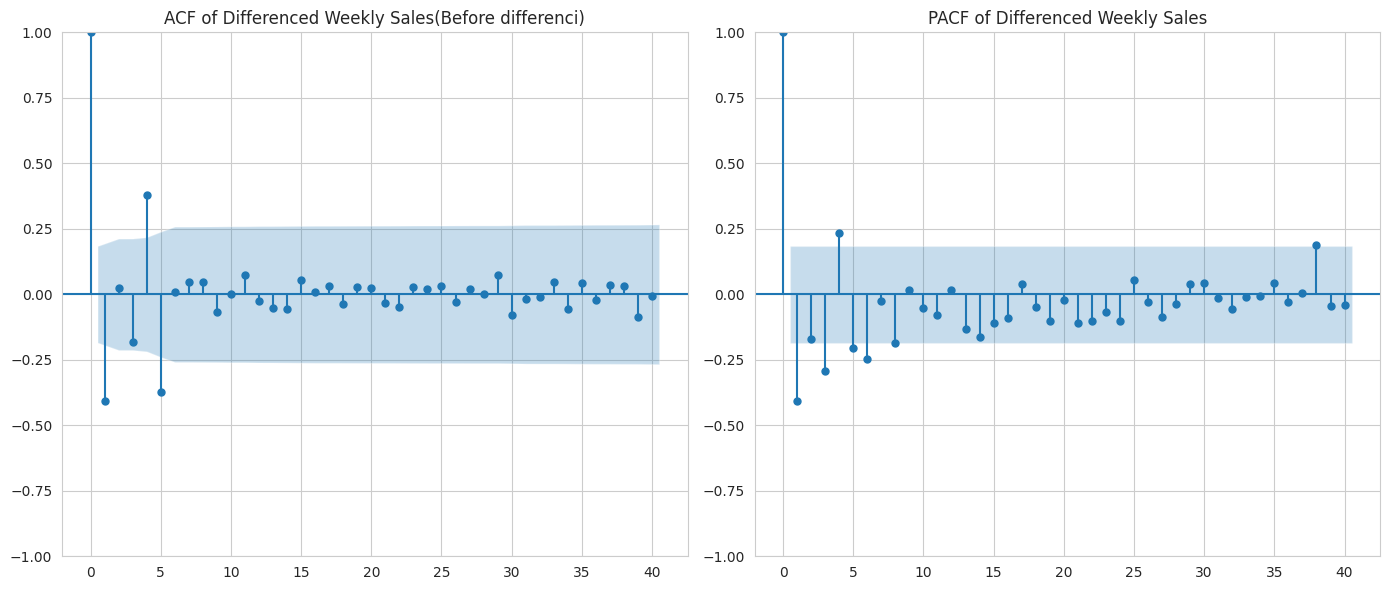

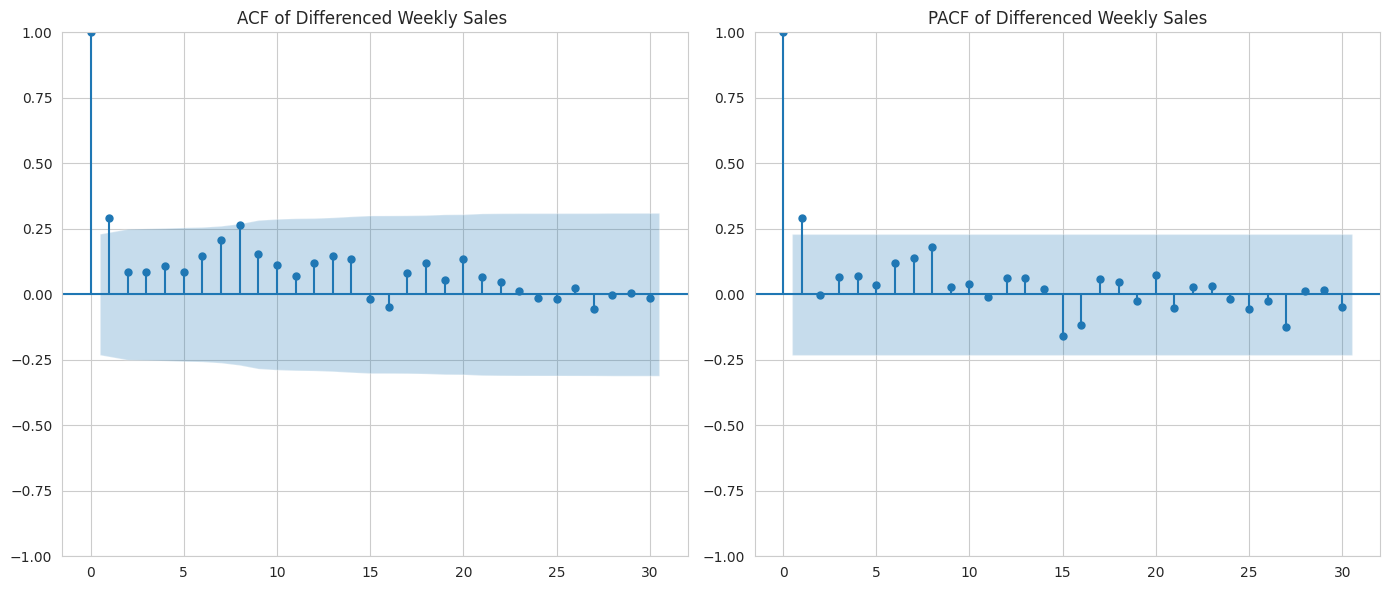

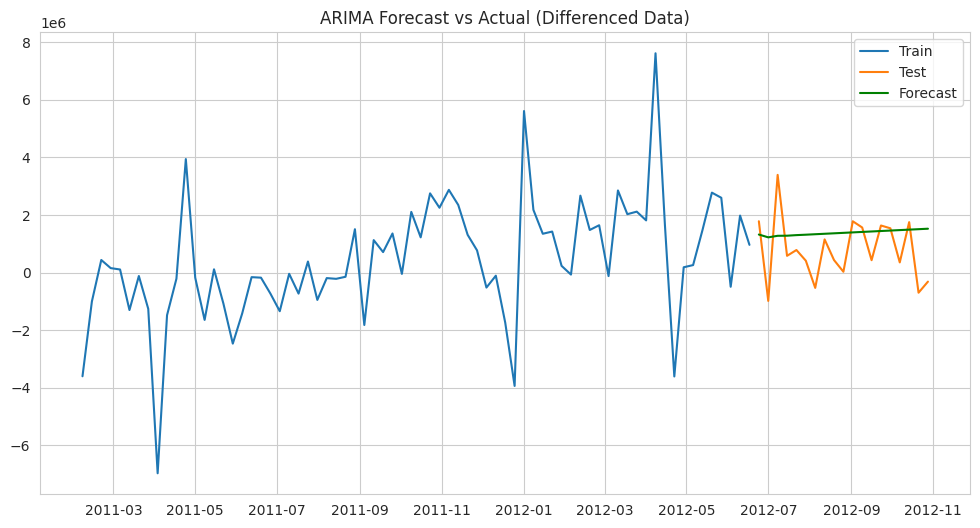

In [ ]:
# Resample the data to weekly frequency and aggregate Weekly_Sales
weekly_sales = data['Weekly_Sales'].resample('W').sum()

# Differencing the data to make it stationary
weekly_sales_diff = weekly_sales.diff().dropna()  #To remove trend
weekly_sales_diff_s = weekly_sales.diff(52).dropna()  #To remove seasonality

# Train-test split after removing trend
train_size = int(len(weekly_sales_diff) * 0.8)
train_df, test_df = weekly_sales_diff[:train_size], weekly_sales_diff[train_size:]


plt.figure(figsize=(14,6))

# Plot ACF for Trend differenced Weekly Sales
plt.subplot(1, 2, 1)
plot_acf(train_df, lags=40, ax=plt.gca())
plt.title('ACF of Differenced Weekly Sales(Before differencing)')

# Plot PACF for Trend differenced Weekly Sales
plt.subplot(1, 2, 2)
plot_pacf(train_df, lags=40, ax=plt.gca())
plt.title('PACF of Weekly Sales')

plt.tight_layout()
plt.show()

# Train-test split after removing trend and seasonality
train_size = int(len(weekly_sales_diff_s) * 0.8)
train_df_s, test_df_s = weekly_sales_diff_s[:train_size], weekly_sales_diff_s[train_size:]

# Plot ACF and PACF for the differenced data
plt.figure(figsize=(14, 6))


# Plot ACF for differenced Weekly Sales
plt.subplot(1, 2, 1)
plot_acf(train_df_s, lags=30, ax=plt.gca())
plt.title('ACF of Differenced Weekly Sales ')

# Plot PACF for differenced Weekly Sales
plt.subplot(1, 2, 2)
plot_pacf(train_df_s, lags=30, ax=plt.gca())
plt.title('PACF of Differenced Weekly Sales')

plt.tight_layout()
plt.show()

# Fit the ARIMA model to the training data
model = ARIMA(train_df_s, order=(1, 2, 1))
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=len(test_df_s))
forecast = pd.Series(forecast, index=test_df_s.index)

# Plot forecast vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_df_s, label='Train')
plt.plot(test_df_s, label='Test')
plt.plot(forecast, label='Forecast', color='green')
plt.legend()
plt.title('ARIMA Forecast vs Actual (Differenced Data)')
plt.show()


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate error metrics
mse = mean_squared_error(test_df_s, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_df_s, forecast)
mape = np.mean(np.abs((test_df - forecast) / test_df)) * 100

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

MSE: 1478588517169.9878
RMSE: 1215972.251809221
MAE: 972102.8245666595
MAPE: 691.8963939811356


###SARIMA

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  113
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -957.223
Date:                            Tue, 26 Nov 2024   AIC                           1924.445
Time:                                    19:55:16   BIC                           1934.917
Sample:                                02-14-2010   HQIC                          1928.541
                                     - 04-08-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4452      0.215     -2.068      0.039      -0.867      -0.023
ma.L1         -0.9865      0.325   

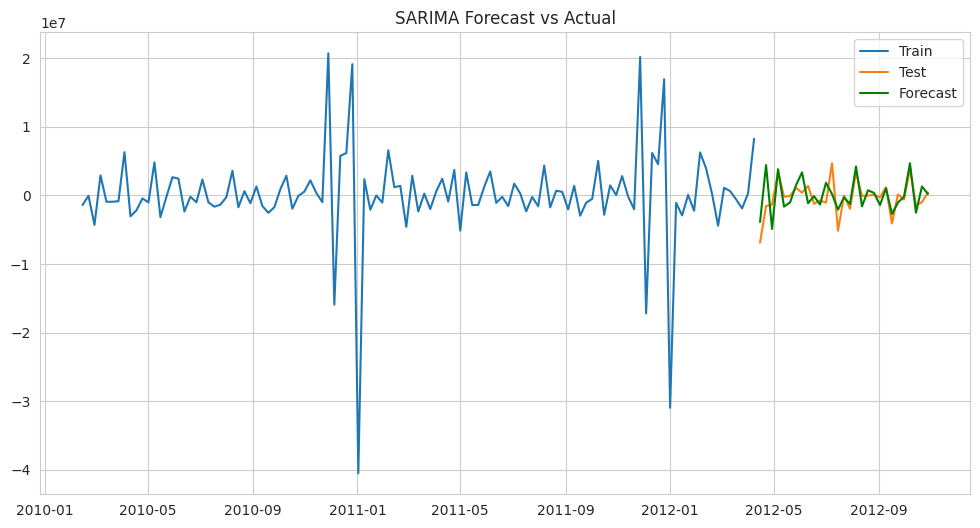

In [ ]:
weekly_sales =  data['Weekly_Sales'].resample('W').sum()
weekly_sales_diff1 = weekly_sales.diff().dropna() #To remove trend


train_size = int(len(weekly_sales_diff1) * 0.8)
train_s, test_s = weekly_sales_diff1[:train_size], weekly_sales_diff1[train_size:]

#Fit SARIMA Model
sarima_model = SARIMAX(train_s, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

#Forecasting
sarima_forecast = sarima_model_fit.forecast(steps=len(test_s))
sarima_forecast = pd.Series(sarima_forecast, index=test_s.index)

#Remove NaN values from the test if exist
test_s = test_s.dropna()
sarima_forecast_clean = sarima_forecast.dropna()


#Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train_s, label='Train')
plt.plot(test_s, label='Test')
plt.plot(sarima_forecast_clean, label='Forecast', color='green')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()



In [ ]:
#Calculate error metrics
mse = mean_squared_error(test_s, sarima_forecast_clean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_s, sarima_forecast_clean)
mape= np.mean(np.abs((test_s - sarima_forecast_clean) / test_s)) * 100
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

MSE: 4522048268709.804
RMSE: 2126510.8202663357
MAE: 1598349.1432291446
MAPE: 350.3475907958565


####PLOT ON ORIGINAL SCALE AND FORECAST NEXT ONE YEAR

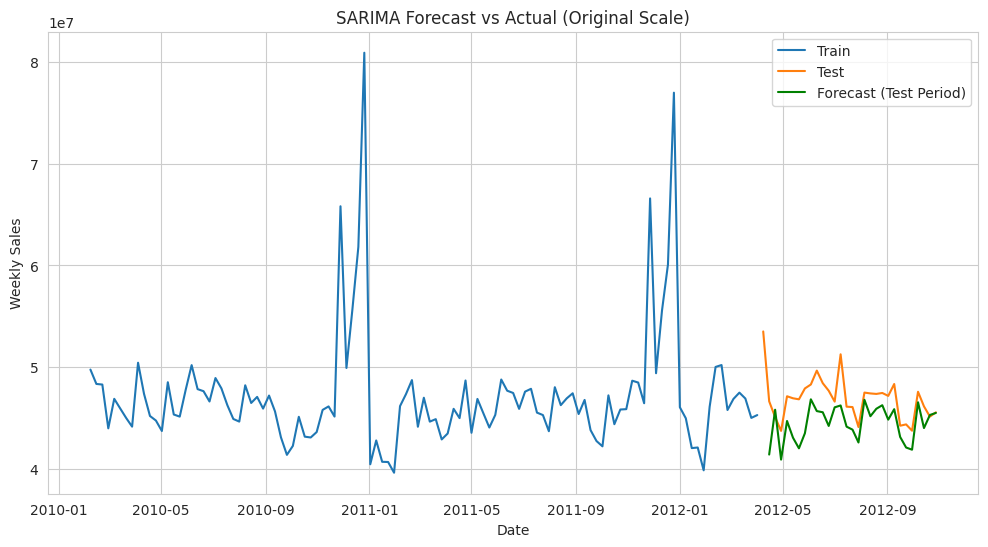

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Forecast on the differenced scale for the test set
sarima_forecast_diff = sarima_model_fit.forecast(steps=len(test_s))
sarima_forecast_diff = pd.Series(sarima_forecast_diff, index=test_s.index)

# Bring test forecast back to original scale
last_train_value = weekly_sales.iloc[train_size - 1]  # Last value before the test set in original data
sarima_forecast_original_scale = sarima_forecast_diff.cumsum() + last_train_value

# Plot forecast vs actual for the test period
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales[:train_size], label='Train')
plt.plot(weekly_sales[train_size:], label='Test')
plt.plot(sarima_forecast_original_scale, label='Forecast (Test Period)', color='green')
plt.legend()
plt.title('SARIMA Forecast vs Actual (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


# Predict future 52 weeks (differenced scale)
future_steps = 52
future_forecast_diff = sarima_model_fit.get_forecast(steps=future_steps)
future_forecast_diff_series = pd.Series(future_forecast_diff.predicted_mean)

# Bring the future forecast back to the original scale
future_forecast_index = pd.date_range(start=weekly_sales.index[-1] + pd.Timedelta(weeks=1), periods=future_steps, freq='W')
last_known_value = weekly_sales.iloc[-1]  # Last known value in the original scale
future_forecast_original_scale = future_forecast_diff_series.cumsum() + last_known_value
future_forecast_original_scale.index = future_forecast_index

# Interactive Plotly visualization
trace_train = go.Scatter(x=weekly_sales[:train_size].index, y=weekly_sales[:train_size], mode='lines', name='Train')
trace_test = go.Scatter(x=weekly_sales[train_size:].index, y=weekly_sales[train_size:], mode='lines', name='Test')
trace_forecast = go.Scatter(x=sarima_forecast_original_scale.index, y=sarima_forecast_original_scale, mode='lines', name='Forecast (Test Period)', line=dict(color='green'))
trace_future_forecast = go.Scatter(x=future_forecast_original_scale.index, y=future_forecast_original_scale, mode='lines', name='Future Forecast (Next 52 Weeks)', line=dict(dash='dash', color='orange'))

# Add traces to the figure
fig = go.Figure([trace_train, trace_test, trace_forecast, trace_future_forecast])

# Update layout
fig.update_layout(title='Sales Forecast with SARIMA (Original Scale)',
                  xaxis_title='Date',
                  yaxis_title='Weekly Sales',
                  template='plotly_white')

# Show interactive plot
fig.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate error metrics on the original scale
test_original_scale = weekly_sales[train_size:]  # Test set on the original scale
sarima_forecast_original_scale_clean = sarima_forecast_original_scale.dropna()  # Remove any NaN if exists

# Ensure the test and forecast data align correctly
test_original_scale = test_original_scale.loc[sarima_forecast_original_scale_clean.index]

# Calculate error metrics
mse_original = mean_squared_error(test_original_scale, sarima_forecast_original_scale_clean)
rmse_original = np.sqrt(mse_original)
mae_original = mean_absolute_error(test_original_scale, sarima_forecast_original_scale_clean)
mape_original = np.mean(np.abs((test_original_scale - sarima_forecast_original_scale_clean) / test_original_scale)) * 100

# Print the error metrics
print('Error Metrics on the Original Scale:')
print('MSE:', mse_original)
print('RMSE:', rmse_original)
print('MAE:', mae_original)
print('MAPE:', mape_original)


Error Metrics on the Original Scale:
MSE: 7270995838097.989
RMSE: 2696478.4141724533
MAE: 2292301.5994444126
MAPE: 4.86729630975833


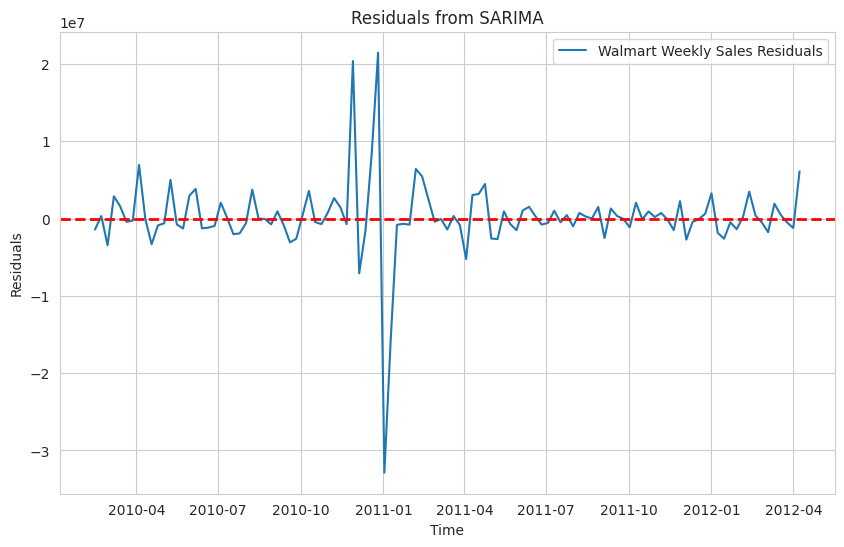

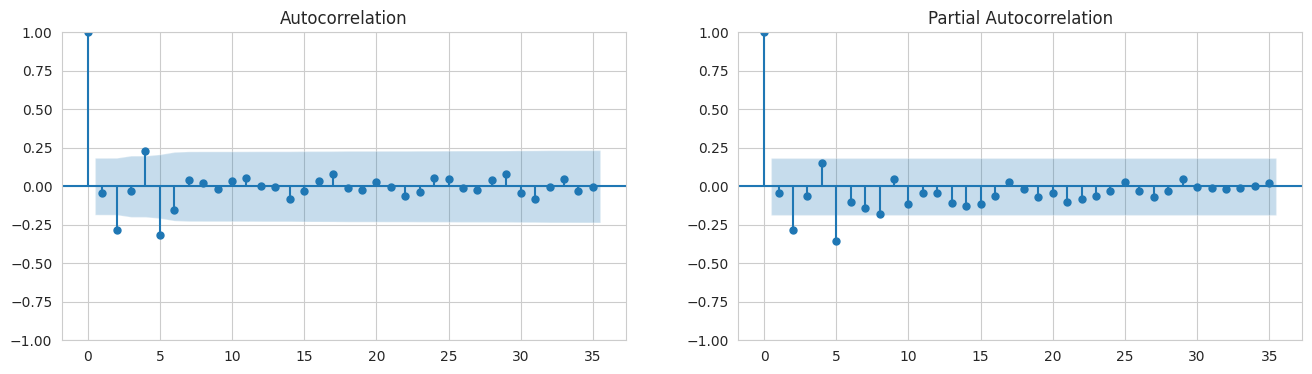

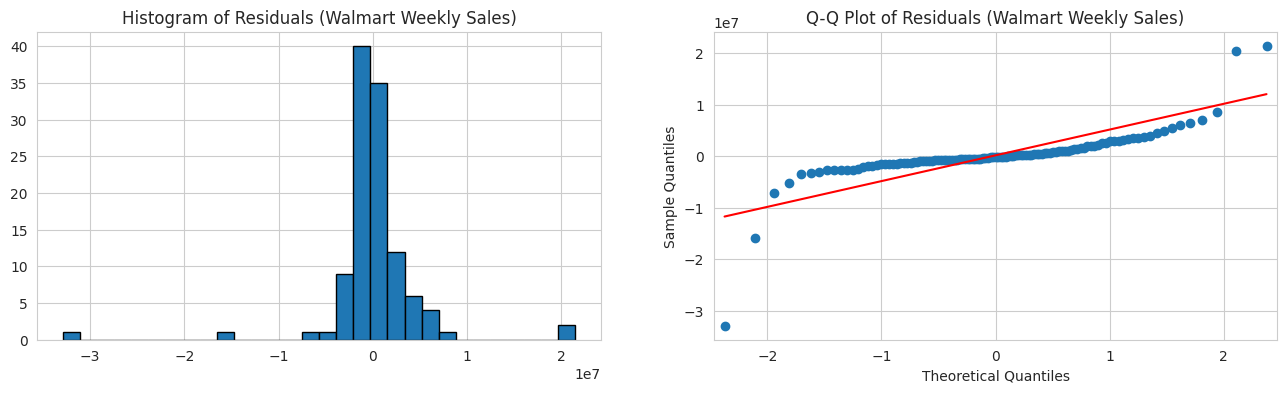

Shapiro Test Statistic: 0.6426932257592276
Shapiro Test p-value: 3.4378261559018802e-15
The residuals are not normally distributed.


In [ ]:
###RESIDUAL ANALYSIS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro

# Get residuals from the fitted ARIMA model for Walmart Weekly Sales
residuals_sales = sarima_model_fit.resid

#Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_sales, label='Walmart Weekly Sales Residuals')
plt.title('Residuals from SARIMA')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.legend()
plt.show()

#ACF and PACF plots for residuals
fig, axes = plt.subplots(1, 2, figsize=(16,4))
sm.graphics.tsa.plot_acf(residuals_sales, lags=35, ax=axes[0])
sm.graphics.tsa.plot_pacf(residuals_sales, lags=35, ax=axes[1])
plt.show()

#Histogram for residuals
fig, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].hist(residuals_sales, bins=30, edgecolor='black')
axes[0].set_title('Histogram of Residuals (Walmart Weekly Sales)')

#Q-Q plot
sm.qqplot(residuals_sales, line='s', ax=axes[1])
axes[1].set_title('Q-Q Plot of Residuals (Walmart Weekly Sales)')
plt.show()

#Shapiro Test to check Normality
shapiro_test_stat, shapiro_p_value = stats.shapiro(residuals_sales)
print(f'Shapiro Test Statistic: {shapiro_test_stat}')
print(f'Shapiro Test p-value: {shapiro_p_value}')

#Interpretation of the result
alpha = 0.05
if shapiro_p_value > alpha:
    print("The residuals are normally distributed.")
else:
    print("The residuals are not normally distributed.")



###LSTM

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - loss: 0.0426 - val_loss: 0.0164
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0406 - val_loss: 0.0065
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0238 - val_loss: 0.0019
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0227 - val_loss: 0.0038
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0205 - val_loss: 0.0048
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0280 - val_loss: 0.0029
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0186 - val_loss: 0.0019
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0209 - val_loss: 0.0018
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0232 - val_loss: 0.0018
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0209 - val_loss: 0.0018
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0185 - val_loss: 0.0019
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0166 - val_loss: 0.0020


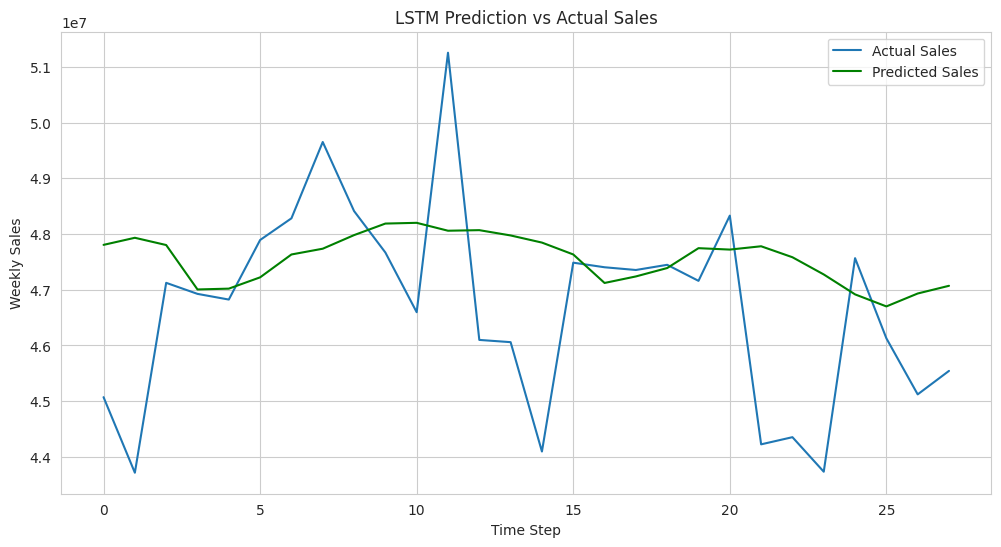

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Data Preparation
# Normalize the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
weekly_sales_scaled = scaler.fit_transform(weekly_sales.values.reshape(-1, 1))

# Function to create a supervised dataset for LSTM
def create_supervised_dataset(data, time_step=4):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Use a time step of 4 weeks (you can adjust as necessary)
time_step = 4
X, y = create_supervised_dataset(weekly_sales_scaled, time_step)

# Reshape the input to be 3D [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 2. Build and Fit LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for forecasting

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# 3. Prediction and Evaluation
# Predict on test data
predicted_scaled = model.predict(X_test)

# Rescale predictions back to the original scale
predicted = scaler.inverse_transform(predicted_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
mse = mean_squared_error(y_test_original, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predicted)
mape = np.mean(np.abs((y_test_original - predicted) / y_test_original)) * 100

# Print error metrics
print('Error Metrics for LSTM:')
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

# Plot actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual Sales')
plt.plot(predicted, label='Predicted Sales', color='green')
plt.legend()
plt.title('LSTM Prediction vs Actual Sales')
plt.xlabel('Time Step')
plt.ylabel('Weekly Sales')
plt.show()
